# Multi-armed bandit
### Thompson sampling with success probability constraint and stochastic rewards

In [1]:
from matplotlib import pyplot as plt

import numpy as np
import ray
import time

from source import simluate_rayleigh_fading_channel
from source import ThompsonSamplingBandit, OuterLoopLinkAdaptation

plt.rcParams.update({'font.size': 22, 'lines.linewidth' : 3})

ray_redis_address = "10.0.0.5:15672"
ray.init(address=ray_redis_address, ignore_reinit_error=True, log_to_driver=False)

2020-02-14 00:35:40,705	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.


{'node_ip_address': '10.0.0.5',
 'object_store_address': '/tmp/ray/session_2020-02-13_23-13-46_710474_26220/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-13_23-13-46_710474_26220/sockets/raylet',
 'redis_address': '10.0.0.5:15672',
 'session_dir': '/tmp/ray/session_2020-02-13_23-13-46_710474_26220',
 'webui_url': None}

In [2]:
@ray.remote
def f():
    time.sleep(0.01)
    return ray.services.get_node_ip_address()

# Get a list of the IP addresses of the nodes that have joined the cluster.
ray_node_ips = set(ray.get([f.remote() for _ in range(1000)]))
print('Number of active Ray nodes: %d'%(len(ray_node_ips)))

Number of active Ray nodes: 1


# Load Offline Model

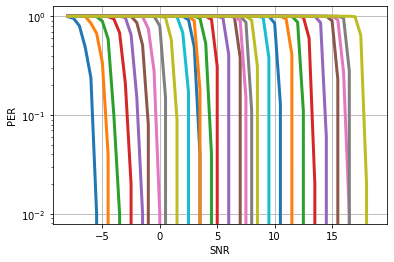

In [3]:
#awgn_datafile = 'AWGN_CUSTOM_CONFIG_DATAFILE.npy'
#awgn_data = np.load( awgn_datafile, encoding='latin1', allow_pickle=True )[ ( ) ]

awgn_datafile = 'AWGN_DATASET.npy'
awgn_data = np.load( awgn_datafile, allow_pickle=True )[ ( ) ]

snr_vs_per = awgn_data['snr_vs_per']
snr_range_dB = awgn_data['snr_range_dB']

#ignore_rate_indices = []#[0, 9, 15, 19, 20, 21]
#snr_vs_per = np.delete(snr_vs_per, ignore_rate_indices, 1)

nrof_snr, nrof_rates = snr_vs_per.shape

plt.figure()
plt.grid(True)
for i in range(nrof_rates):
    plt.semilogy(snr_range_dB, snr_vs_per[:, i])
plt.xlabel( 'SNR' )
plt.ylabel( 'PER')
    
plt.show()

In [4]:
#packet_sizes = [ 20, 20, 40, 64, 84, 104, 124, 148, 168, 148, 188, 232, 272, 316, 356, 400, 408, 472, 536, 900, 660, 724 ]
#packet_sizes = [r for i, r in enumerate(packet_sizes) if i not in ignore_rate_indices]

packet_sizes = [152, 200, 248, 320, 408, 504, 600, 712, 808, 936, 
                936, 1032, 1192, 1352, 1544, 1736, 1800, 
                1800, 1928, 2152, 2344, 2600, 2792, 2984, 3240, 3496, 3624, 3752, 4008]

modorders    = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                4, 4, 4, 4, 4, 4, 4, 
                6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

target_per = 0.1
cqi_delay = 32

In [5]:
#code_rates = [p / (72 * 12 * m ) * 1024 for p, m in zip( packet_sizes, modorders) ]
#print( [(i, m, c) for i, m, c in zip( range( len(modorders)) , modorders, code_rates)] )
#REF_MCS_INDICES = [0, 1, 3, 5, 8, 9, 11, 14, 16, 20, 22, 24, 27, 28, 28]

In [6]:
#from source import determine_cqi_from_sinr

#cqi = []
#for s in snr_range_dB:
#    cqi.append( determine_cqi_from_sinr(s, packet_sizes, awgn_data) )
    
#plt.plot( snr_range_dB, cqi )
#plt.xlabel('Instantaneous SNR [dB]')
#plt.ylabel('CQI')

In [7]:
@ray.remote
def run_experiment( seed, nrof_ttis = 500, cqi_delay = 0, avg_snr_dB = 20  ):
    
    from source import simluate_rayleigh_fading_channel
    from source import ThompsonSamplingBandit, OuterLoopLinkAdaptation

    packet_error_probabilities, channel_quality_indices = simluate_rayleigh_fading_channel( nrof_ttis, 
                                                                                            avg_snr_dB, 
                                                                                            awgn_data, 
                                                                                            packet_sizes, 
                                                                                            norm_doppler = 0.1, 
                                                                                            seed = seed )

    # Pre-generate ACK events for all rates for all channel samples
    packet_acks = np.ndarray( ( nrof_ttis, nrof_rates ) )
    for tti in range( nrof_ttis ):
        for rate_index in range( nrof_rates ):
            packet_acks[tti, rate_index] = np.random.uniform( ) > packet_error_probabilities[tti, rate_index]

    # Thompson Sampling
    ts_bandit = ThompsonSamplingBandit(nrof_rates, packet_sizes, target_per)
    #ts_bandit = OuterLoopLinkAdaptationNew(nrof_rates, packet_sizes, awgn_data, target_per, olla_step_size=0.1)
    
    ts_rates  = [] 
    ts_acks  = []
    ts_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]
        selected_rate_index = ts_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        ts_bandit.update( selected_rate_index, cqi, ack )

        ts_rates.append( selected_rate_index )
        ts_acks.append( ack )
        ts_tputs.append( packet_sizes[ selected_rate_index ] * ack )
    
    
    
    # Outer Loop Link Adaptation
    olla_bandit = OuterLoopLinkAdaptation(nrof_rates, packet_sizes, awgn_data, target_per, olla_step_size=0.3)
    
    olla_rates  = []
    olla_acks  = []
    olla_tputs = []
    for tti in range( nrof_ttis ):
        
        # Skip the first few samples to account for CQI delay
        if tti < cqi_delay:
            continue
            
        cqi = channel_quality_indices[tti]    
        selected_rate_index = olla_bandit.act( cqi )

        ack = packet_acks[tti, selected_rate_index]
        olla_bandit.update( selected_rate_index, cqi, ack )

        olla_rates.append(selected_rate_index)
        olla_acks.append(ack)
        olla_tputs.append( packet_sizes[ selected_rate_index ] * ack )
    
    return ( ts_rates, ts_acks, ts_tputs, olla_rates, olla_acks, olla_tputs)

In [8]:
ts_mcs = []
ts_ack = []
ts_tput = []

olla_mcs = []
olla_ack = []
olla_tput = []

results = ray.get( [ run_experiment.remote( seed = i ) for i in range(16) ] )

for res in results:
    ts_mcs.append( res[0] )
    ts_ack.append( res[1] )
    ts_tput.append( res[2] )
    
    olla_mcs.append( res[3] )
    olla_ack.append( res[4] )
    olla_tput.append( res[5] )

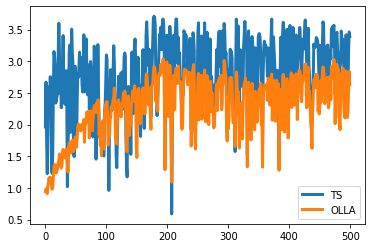

In [9]:
plt.plot(np.mean(np.array(ts_tput)[:, :] / (72 * 15), axis=0))
plt.plot(np.mean(np.array(olla_tput)[:, :] / (72 * 15), axis=0))

plt.legend(['TS', 'OLLA'])

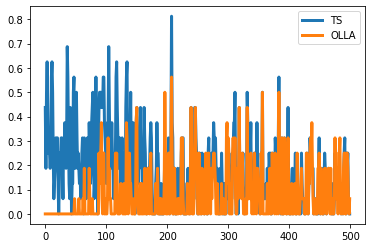

In [10]:
plt.plot(1.0 - np.mean(np.array(ts_ack)[:, :], axis=0))
plt.plot(1.0 - np.mean(np.array(olla_ack)[:, :], axis=0))

plt.legend(['TS', 'OLLA'])

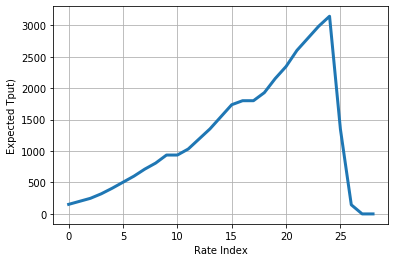

In [11]:
from source import determine_per_at_sinr

packet_error_probabilities = determine_per_at_sinr( 15, awgn_data)
expected_tputs = [ (1-per) * psize for per, psize in zip( packet_error_probabilities, packet_sizes )]

plt.figure()
plt.grid(True)
plt.plot(expected_tputs)

plt.xlabel('Rate Index')
plt.ylabel('Expected Tput)')
plt.show()

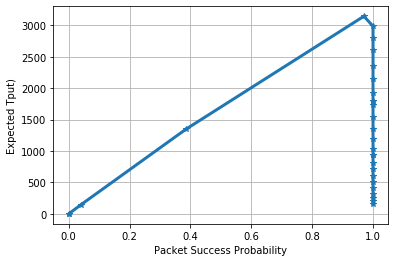

In [12]:
plt.figure()
plt.grid(True)
plt.plot(1.0 - packet_error_probabilities, expected_tputs, '-*')

plt.xlabel('Packet Success Probability')
plt.ylabel('Expected Tput)')
plt.show()